In [2]:
import pandas as pd
import numpy as np
#from pandas_datareader import data, wb
import datetime
import pprint

import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage
from IPython.core.display import display, HTML

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)
pp = pprint.PrettyPrinter(indent=4)

exo_list = storage.exo_list()
pp.pprint(exo_list)

[   'ES_BullishCollarBW',
    'ES_BearishCollarBW',
    'ES_CallSpread',
    'ES_PutSpread',
    'CL_BullishCollarBW',
    'CL_BearishCollarBW',
    'CL_CallSpread',
    'CL_PutSpread',
    'NG_BullishCollarBW',
    'NG_BearishCollarBW',
    'NG_CallSpread',
    'NG_PutSpread',
    'ES_ContFut',
    'NG_ContFut',
    'CL_ContFut',
    'ZC_BullishCollarBW',
    'ZC_BearishCollarBW',
    'ZC_CallSpread',
    'ZC_PutSpread',
    'ZC_ContFut',
    'ZN_BullishCollarBW',
    'ZN_BearishCollarBW',
    'ZN_CallSpread',
    'ZN_PutSpread',
    'ZN_ContFut']


In [98]:
#exo_series, exo_dict = storage.load_series('CL_PutSpread')
exo_series, exo_dict = storage.load_series('CL_PutSpread')
exo_series = exo_series[exo_series.columns[0]]

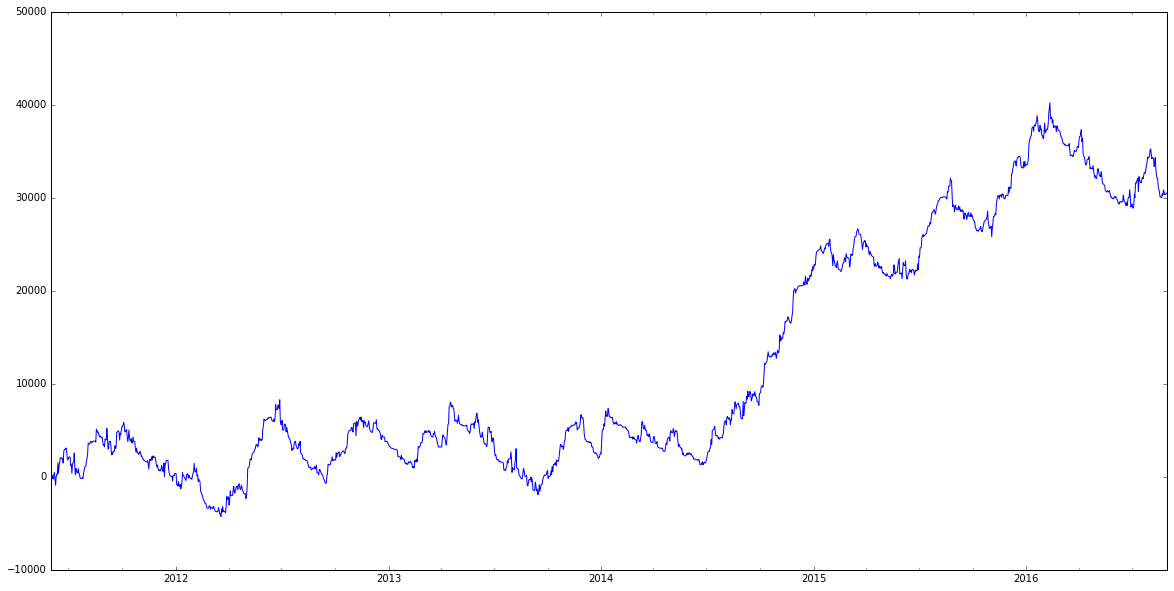

In [99]:
figsize(20,10)
exo_series.plot()

## Renko calculation

## High/Low of renko bricks is only needed for visual representation

In [91]:
box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

# Simple renko algorihtm

df = pd.DataFrame()
df['close'] = exo_series

atr_period = 60

O = L = H = C = df['close']
period = atr_period

atr = ATR(H, L, C, period)

atr_multiplier = 2

for i in range(len(df)):
    box_size = (atr*atr_multiplier).shift(1)[i]
    
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start
        
        # First of all we need to set box size. 
        # Then calculate price movement. 
        # If price movement is more or equal than box size - renko bar(or bars) will be added
        
        if np.abs(price_move) >= box_size:
            
            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much renko bars will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_index = df.close.index[i]

            for b in range(int(box_quantity)):
            # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
            # So renko bar 1 will have next parameters - 
            # 1)index 2015-01-01
            # 2)open = 100
            # 3)close = 110(box_start + box_size)
            # 4)type = up
            
            # Next renko bar will have next parameters -
            # 1)index 2015-01-01
            # 2)open = 110(previous renko bar close)
            # 3)close = 120(open + box_size)
            # 4)type = up
            
            # And so on..
            
            # After all we adding renko bars dict to list and convert it to DF
            
                if price_move > 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:
                        d = {'date': box_index, 'open': box_end, 'close': box_end + box_size,
                            'type': 'up'}
                        
                        box_end = d['close']
                        temp_l.append(d)

                if price_move < 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:           
                        d = {'date': box_index, 'open': box_end, 'close': box_end - box_size, 
                             'type': 'down'}
                        
                        box_end = d['close']
                        temp_l.append(d)
                        
            box_start = df.close[i]
            
renko_df = pd.DataFrame(temp_l)

del temp_l

In [92]:
period_slow = 20
period_fast = 10

slow_ma = renko_df.close.rolling(period_slow).mean()
fast_ma = renko_df.close.rolling(period_fast).mean()

# Enry/exit rules
renko_df['crossdown'] = CrossDown(fast_ma, slow_ma)
renko_df['crossup'] = CrossUp(fast_ma, slow_ma)

In [93]:
renko_df

,close,date,open,type,crossdown,crossup
0,359.847007,2011-05-01,35.400966,up,False,False
1,684.293049,2011-05-01,359.847007,up,False,False
2,1001.390921,2011-05-04,684.293049,up,False,False
3,1325.063609,2011-05-06,1001.390921,up,False,False
4,1648.994032,2011-05-16,1325.063609,up,False,False
5,1966.664196,2011-05-23,1648.994032,up,False,False
6,2279.061134,2011-05-26,1966.664196,up,False,False
7,2589.844796,2011-05-30,2279.061134,up,False,False
8,2893.056713,2011-06-01,2589.844796,up,False,False
9,3196.268629,2011-06-01,2893.056713,up,False,False


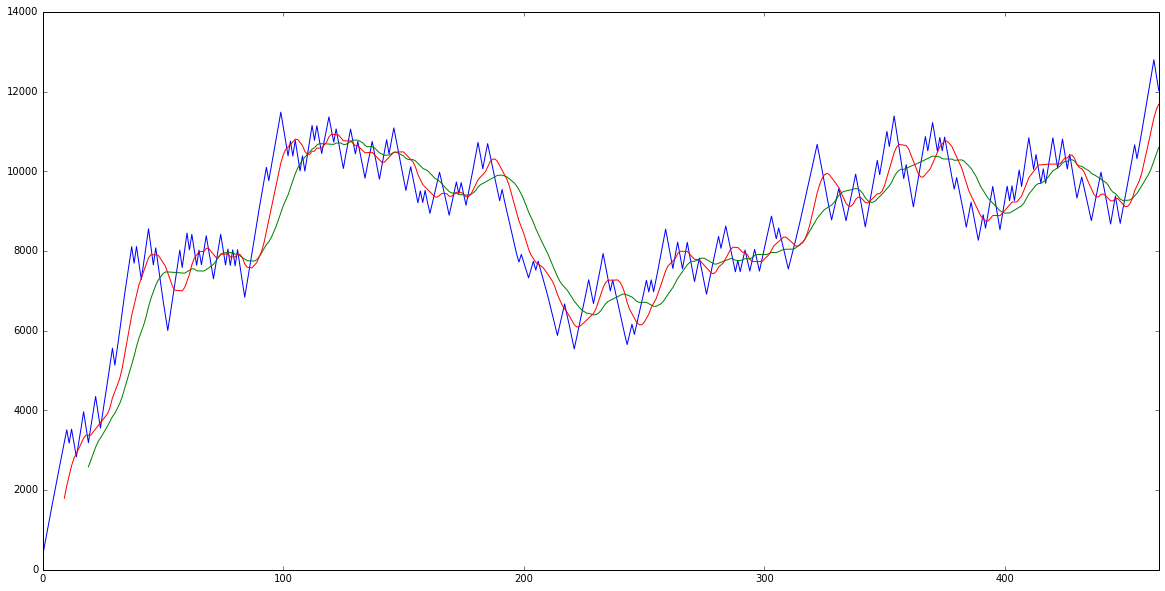

In [94]:
renko_df.close.plot()
slow_ma.plot()
fast_ma.plot()

In [95]:
df = df.join(renko_df.set_index('date')[['crossdown','crossup']])
df = df.fillna(False).groupby(df.index).any()


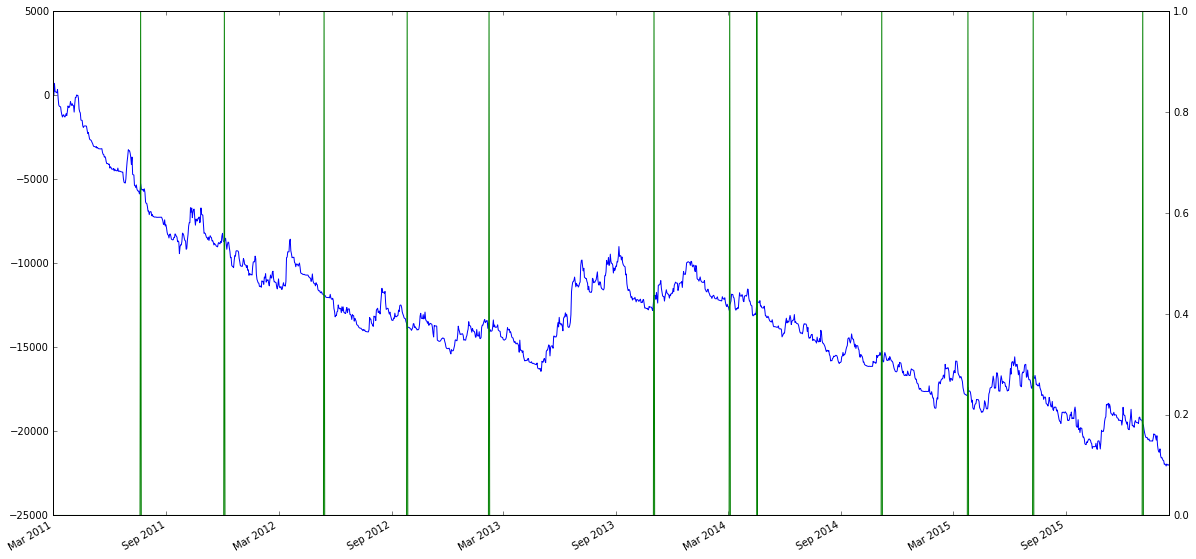

In [88]:
df.close.plot()
df.crossdown.plot(secondary_y=True)
#df.crossup.plot(secondary_y=True)

In [77]:
df.ix['2011-08-17':'2011-08-21']

,close,crossdown,crossup
2011-08-18,6296.013246,False,False
2011-08-18,6296.013246,False,False
2011-08-18,6296.013246,True,False
2011-08-19,6708.138671,False,False
2011-08-20,6669.280122,False,False
2011-08-21,6644.919608,False,False
